            City                 Region  Year  UHI_Intensity  Urban_Radiance  \
0        Phoenix              Southwest  2017      10.568801       27.602593   
1        Phoenix              Southwest  2018       9.857040       25.072786   
2        Phoenix              Southwest  2019      11.021978       26.835787   
3        Phoenix              Southwest  2020      10.383381       26.759691   
4        Phoenix              Southwest  2021      10.095655       25.761341   
..           ...                    ...   ...            ...             ...   
142  Sioux Falls  Northern Great Plains  2019       4.590560       11.080895   
143  Sioux Falls  Northern Great Plains  2020       4.118678       11.639478   
144  Sioux Falls  Northern Great Plains  2021       4.778841       11.467551   
145  Sioux Falls  Northern Great Plains  2022       3.786116       11.708399   
146  Sioux Falls  Northern Great Plains  2023       5.017206       11.351861   

     Rural_Radiance  Radiance_Differenc

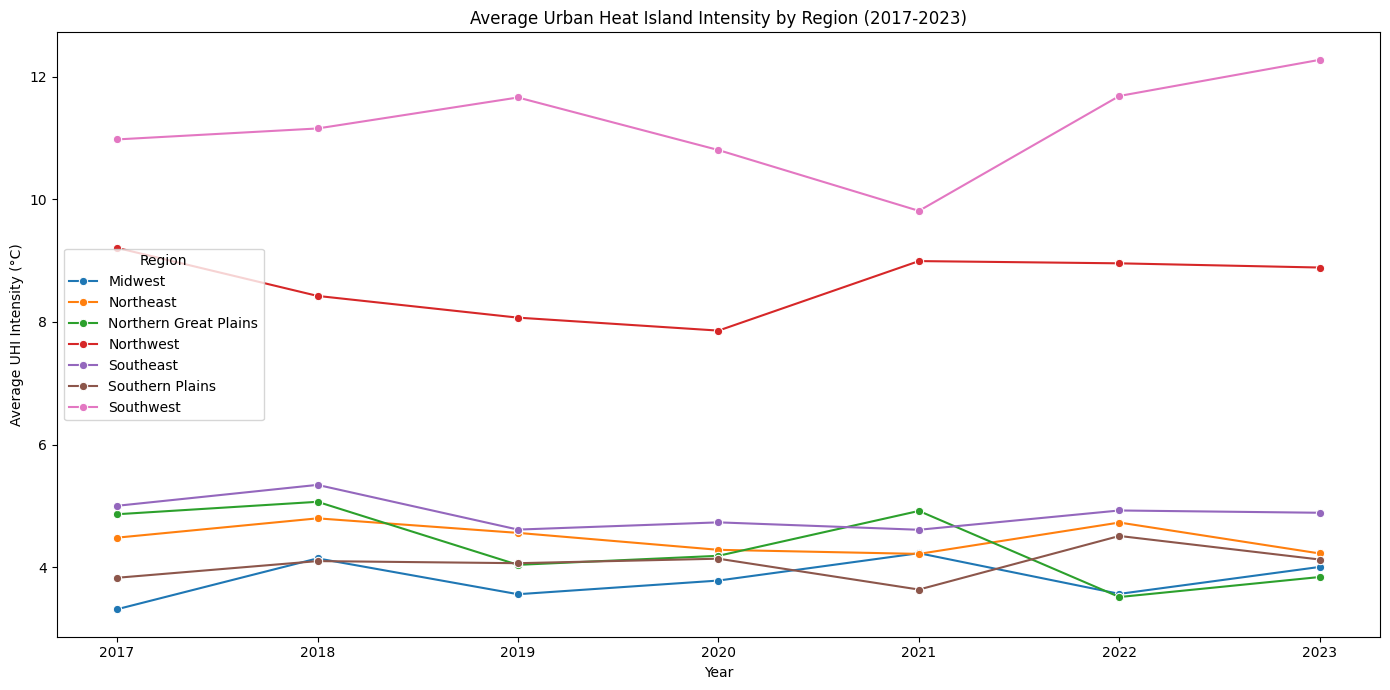

C:\Users\Shawn\AppData\Local\Temp\ipykernel_29992\4049222465.py:250: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_avg, x='Region', y='UHI_Intensity', palette='viridis')


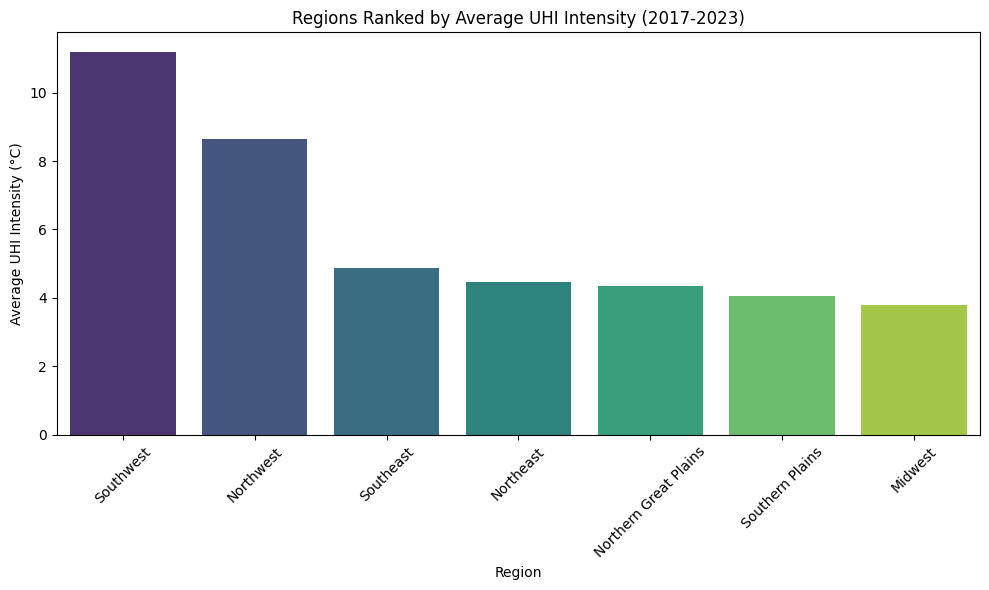

Correlation between UHI Intensity and Radiance Difference: 0.23803480522114753


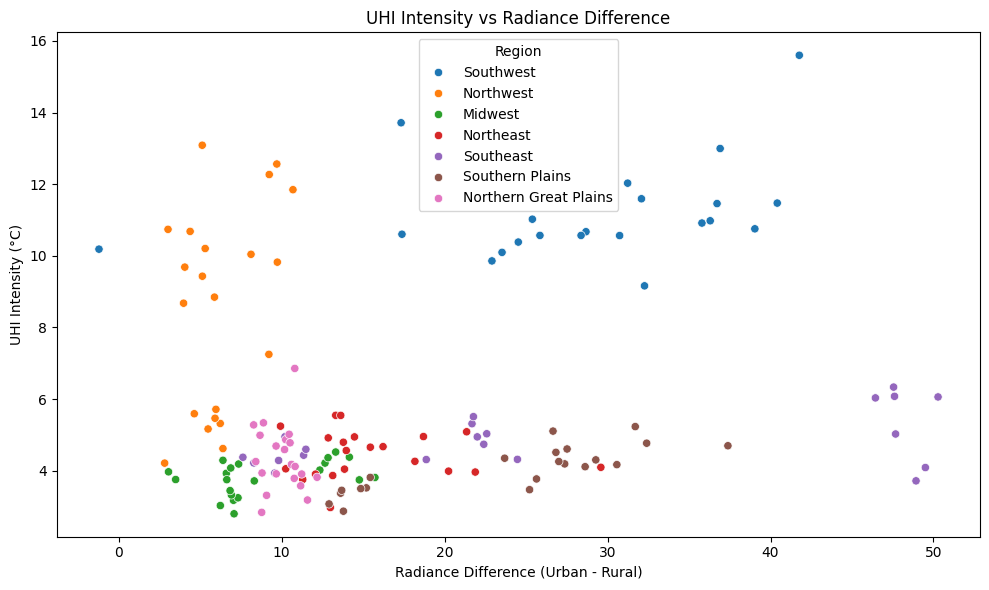

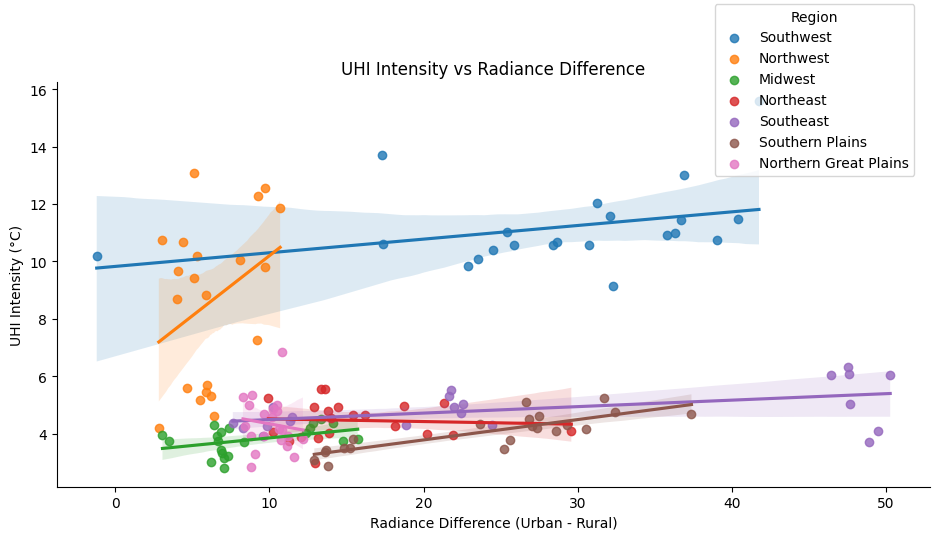

In [5]:
import ee
import geemap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Google Earth Engine
ee.Authenticate()
ee.Initialize()

# Define the list of cities with their corresponding counties, state codes, and regions
cities = [
    # Southwest
    {'name': 'Phoenix', 'county_name': 'Maricopa', 'state_code': '04', 'region': 'Southwest'},      # Arizona
    {'name': 'Los Angeles', 'county_name': 'Los Angeles', 'state_code': '06', 'region': 'Southwest'},  # California
    {'name': 'Las Vegas', 'county_name': 'Clark', 'state_code': '32', 'region': 'Southwest'},        # Nevada

    # Northwest
    {'name': 'Seattle', 'county_name': 'King', 'state_code': '53', 'region': 'Northwest'},           # Washington
    {'name': 'Portland', 'county_name': 'Multnomah', 'state_code': '41', 'region': 'Northwest'},     # Oregon
    {'name': 'Boise', 'county_name': 'Ada', 'state_code': '16', 'region': 'Northwest'},              # Idaho

    # Midwest
    {'name': 'Chicago', 'county_name': 'Cook', 'state_code': '17', 'region': 'Midwest'},             # Illinois
    {'name': 'Minneapolis', 'county_name': 'Hennepin', 'state_code': '27', 'region': 'Midwest'},     # Minnesota
    {'name': 'Detroit', 'county_name': 'Wayne', 'state_code': '26', 'region': 'Midwest'},            # Michigan

    # Northeast
    {'name': 'New York', 'county_name': 'New York', 'state_code': '36', 'region': 'Northeast'},      # New York
    {'name': 'Boston', 'county_name': 'Suffolk', 'state_code': '25', 'region': 'Northeast'},         # Massachusetts
    {'name': 'Philadelphia', 'county_name': 'Philadelphia', 'state_code': '42', 'region': 'Northeast'},  # Pennsylvania

    # Southeast
    {'name': 'Miami', 'county_name': 'Miami-Dade', 'state_code': '12', 'region': 'Southeast'},       # Florida
    {'name': 'Atlanta', 'county_name': 'Fulton', 'state_code': '13', 'region': 'Southeast'},         # Georgia
    {'name': 'Charlotte', 'county_name': 'Mecklenburg', 'state_code': '37', 'region': 'Southeast'},  # North Carolina

    # South Central
    {'name': 'Houston', 'county_name': 'Harris', 'state_code': '48', 'region': 'Southern Plains'},     # Texas
    {'name': 'Dallas', 'county_name': 'Dallas', 'state_code': '48', 'region': 'Southern Plains'},      # Texas
    {'name': 'Austin', 'county_name': 'Travis', 'state_code': '48', 'region': 'Southern Plains'},      # Texas

    # Northern Great Plains
    {'name': 'Omaha', 'county_name': 'Douglas', 'state_code': '31', 'region': 'Northern Great Plains'},      # Nebraska
    {'name': 'Lincoln', 'county_name': 'Lancaster', 'state_code': '31', 'region': 'Northern Great Plains'},  # Nebraska
    {'name': 'Sioux Falls', 'county_name': 'Minnehaha', 'state_code': '46', 'region': 'Northern Great Plains'}  # South Dakota

]

# Define the list of years from 2017 to 2023
years = list(range(2017, 2024))

# Function to get AOI for a given county and state
def get_aoi(county_name, state_code):
    return ee.FeatureCollection("TIGER/2018/Counties") \
        .filter(ee.Filter.And(
            ee.Filter.eq('NAME', county_name),
            ee.Filter.eq('STATEFP', state_code)
        )).geometry()

# Function to process data for a given AOI and year
def process_data(aoi, start_date, end_date):
    # Import and process Landsat 8 data
    image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date) \
        .map(apply_scale_factors) \
        .map(cloud_mask)
    
    # Check if the collection is empty
    collection_size = image_collection.size().getInfo()
    if collection_size == 0:
        return None, None, None, None
    
    image = image_collection.median().clip(aoi)
    
    # Calculate NDVI
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    
    # Calculate Emissivity (EM)
    em = calculate_lst_em(ndvi, aoi)
    
    # Thermal band
    thermal = image.select('ST_B10').rename('thermal')
    
    # Calculate LST
    lst = thermal.expression(
        '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15', {
            'TB': thermal.select('thermal'),
            'em': em
        }).rename('LST')
    
    # Classify Urban and Rural Areas
    dynamic_world = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1") \
        .filterDate(start_date, end_date) \
        .filterBounds(aoi) \
        .mosaic()
    
    built_areas = dynamic_world.select('label').eq(6)
    urban_lst = lst.updateMask(built_areas)
    rural_lst = lst.updateMask(ndvi.gte(0.5))  # Adjusted NDVI threshold for rural areas
    
    # Calculate mean LST values
    urban_mean_lst = urban_lst.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).get('LST')
    
    rural_mean_lst = rural_lst.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).get('LST')
    
    # Get VIIRS DNB data
    viirs_dnb = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG') \
        .filterDate(start_date, end_date) \
        .filterBounds(aoi)
    
    # Check if the VIIRS collection is empty
    viirs_collection_size = viirs_dnb.size().getInfo()
    if viirs_collection_size == 0:
        urban_mean_radiance = None
        rural_mean_radiance = None
    else:
        viirs_image = viirs_dnb.mean().clip(aoi)
        # Get the 'avg_rad' band (Average Radiance)
        radiance_band = viirs_image.select('avg_rad')

        # Urban radiance
        urban_radiance = radiance_band.updateMask(built_areas)
        urban_mean_radiance = urban_radiance.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=500,  # Adjusted scale for VIIRS data
            maxPixels=1e9
        ).get('avg_rad')

        # Rural radiance
        rural_radiance = radiance_band.updateMask(ndvi.gte(0.5))
        rural_mean_radiance = rural_radiance.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=500,  # Adjusted scale for VIIRS data
            maxPixels=1e9
        ).get('avg_rad')
    
    return urban_mean_lst, rural_mean_lst, urban_mean_radiance, rural_mean_radiance

# Helper functions
def apply_scale_factors(image):
    opticalBands = image.select('SR_B.*').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

def cloud_mask(image):
    cloudShadowBitmask = (1 << 3)
    cloudBitmask = (1 << 5)
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitmask).eq(0) \
            .And(qa.bitwiseAnd(cloudBitmask).eq(0))
    return image.updateMask(mask)

def calculate_lst_em(ndvi_image, aoi):
    ndvi_min = ee.Number(ndvi_image.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).values().get(0))
    
    ndvi_max = ee.Number(ndvi_image.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).values().get(0))
    
    fv = ((ndvi_image.subtract(ndvi_min)).divide(ndvi_max.subtract(ndvi_min))).pow(2).rename('FV')
    em = fv.multiply(0.004).add(0.986).rename('EM')
    return em

# Create an empty list to store results
results = []

# Loop over cities and years
for city in cities:
    city_name = city['name']
    county_name = city['county_name']
    state_code = city['state_code']
    region = city['region']
    aoi = get_aoi(county_name, state_code)
    
    for year in years:
        # Adjust start and end dates to match monthly composites
        start_date = f'{year}-06-01'
        end_date = f'{year}-09-30'
        
        urban_mean_lst, rural_mean_lst, urban_mean_radiance, rural_mean_radiance = process_data(aoi, start_date, end_date)
        
        if (urban_mean_lst is not None and rural_mean_lst is not None and
            urban_mean_radiance is not None and rural_mean_radiance is not None):
            urban_mean = ee.Number(urban_mean_lst).getInfo()
            rural_mean = ee.Number(rural_mean_lst).getInfo()
            uhi_intensity = urban_mean - rural_mean

            urban_rad = ee.Number(urban_mean_radiance).getInfo()
            rural_rad = ee.Number(rural_mean_radiance).getInfo()
            rad_difference = urban_rad - rural_rad

            results.append({
                'City': city_name,
                'Region': region,
                'Year': year,
                'UHI_Intensity': uhi_intensity,
                'Urban_Radiance': urban_rad,
                'Rural_Radiance': rural_rad,
                'Radiance_Difference': rad_difference
            })
        else:
            print(f"No data for {city_name} in {year}")

# Convert results to DataFrame
df = pd.DataFrame(results)

# Display the DataFrame
print(df)

# Calculate average UHI Intensity per region per year
region_year_group = df.groupby(['Region', 'Year'])['UHI_Intensity'].mean().reset_index()

# Plotting the UHI Intensity by Region over the Years
plt.figure(figsize=(14, 7))
sns.lineplot(data=region_year_group, x='Year', y='UHI_Intensity', hue='Region', marker='o')
plt.title('Average Urban Heat Island Intensity by Region (2017-2023)')
plt.ylabel('Average UHI Intensity (°C)')
plt.xlabel('Year')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

# Calculate overall average UHI Intensity per region
region_avg = df.groupby('Region')['UHI_Intensity'].mean().reset_index().sort_values(by='UHI_Intensity', ascending=False)

# Plotting the Regions Ranked by Average UHI Intensity
plt.figure(figsize=(10, 6))
sns.barplot(data=region_avg, x='Region', y='UHI_Intensity', palette='viridis')
plt.title('Regions Ranked by Average UHI Intensity (2017-2023)')
plt.ylabel('Average UHI Intensity (°C)')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze correlation between UHI Intensity and Radiance Difference
corr = df['UHI_Intensity'].corr(df['Radiance_Difference'])
print("Correlation between UHI Intensity and Radiance Difference:", corr)

# Scatter plot of UHI Intensity vs Radiance Difference
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Radiance_Difference', y='UHI_Intensity', hue='Region')
plt.title('UHI Intensity vs Radiance Difference')
plt.xlabel('Radiance Difference (Urban - Rural)')
plt.ylabel('UHI Intensity (°C)')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

g = sns.lmplot(
    data=df, 
    x='Radiance_Difference', 
    y='UHI_Intensity', 
    hue='Region', 
    aspect=1.5
)

# Access the legend from the FacetGrid
legend = g._legend
# Set a new location using bbox_to_anchor and loc
legend.set_bbox_to_anchor((0.97, 0.9)) 
legend.set_frame_on(True)
legend.set_title("Region")

plt.title('UHI Intensity vs Radiance Difference')
plt.xlabel('Radiance Difference (Urban - Rural)')
plt.ylabel('UHI Intensity (°C)')
plt.tight_layout()
plt.show()


In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Convert Year and Region to categorical for model
df['Region'] = df['Region'].astype('category')
df['Year'] = df['Year'].astype('category')

# Fit a linear model: UHI_Intensity ~ Radiance_Difference + Region + Year
model = smf.ols('UHI_Intensity ~ Radiance_Difference + C(Region) + C(Year)', data=df).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          UHI_Intensity   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     44.87
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           3.69e-42
Time:                        09:36:52   Log-Likelihood:                -243.93
No. Observations:                 147   AIC:                             515.9
Df Residuals:                     133   BIC:                             557.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [7]:
from statsmodels.stats.anova import anova_lm

# Simplify to a model with just Region as a factor
model_region = smf.ols('UHI_Intensity ~ C(Region)', data=df).fit()
anova_results = anova_lm(model_region, typ=2)
print(anova_results)


                sum_sq     df          F        PR(>F)
C(Region)  1026.776518    6.0  94.325943  1.079294e-46
Residual    253.992889  140.0        NaN           NaN


In [8]:
import statsmodels.formula.api as smf

# Fit a mixed-effects model:
# - "C(Region)" and "Radiance_Difference" as fixed effects
# - "City" as a random effect (random intercept)
model_mixed = smf.mixedlm("UHI_Intensity ~ Radiance_Difference + C(Region) + C(Year)", 
                          data=df, 
                          groups=df["City"]).fit()
print(model_mixed.summary())


                    Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       UHI_Intensity
No. Observations:       147           Method:                   REML         
No. Groups:             21            Scale:                    0.6822       
Min. group size:        7             Log-Likelihood:           -205.6473    
Max. group size:        7             Converged:                Yes          
Mean group size:        7.0                                                  
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           3.469    0.771  4.498 0.000  1.958  4.981
C(Region)[T.Northeast]              0.412    1.045  0.395 0.693 -1.636  2.461
C(Region)[T.Northern Great Plains]  0.502    1.039  0.483 0.629 -1.535  2.538
C(Regi

In [9]:
import scipy.stats as stats

groups = [group['UHI_Intensity'].values for name, group in df.groupby('Region')]
h_stat, p_value = stats.kruskal(*groups)
print("Kruskal-Wallis H-statistic:", h_stat, "p-value:", p_value)


Kruskal-Wallis H-statistic: 94.406324692039 p-value: 3.674810942409353e-18


C:\Users\Shawn\AppData\Local\Temp\ipykernel_29992\2255228745.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['UHI_Intensity'].values for name, group in df.groupby('Region')]


R^2 on Test Set: 0.6983325856536919


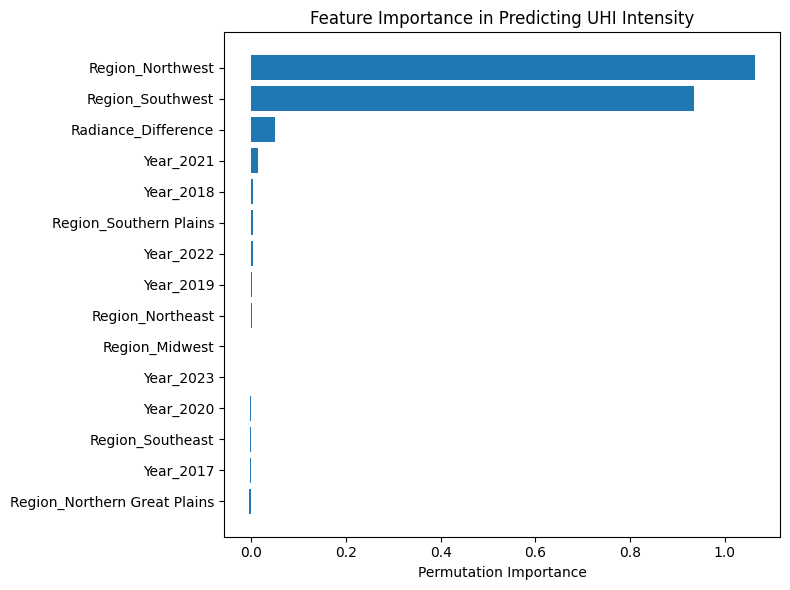

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# Prepare data for ML model
X = df[['Radiance_Difference', 'Region', 'Year']]
y = df['UHI_Intensity']

# One-hot encode categorical features
X_enc = pd.get_dummies(X, columns=['Region', 'Year'])

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

print("R^2 on Test Set:", rf.score(X_test, y_test))

# Check feature importance
importances = permutation_importance(rf, X_test, y_test, random_state=42)
sorted_idx = importances.importances_mean.argsort()

plt.figure(figsize=(8, 6))
plt.barh(X_enc.columns[sorted_idx], importances.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance in Predicting UHI Intensity")
plt.tight_layout()
plt.show()


C:\Users\Shawn\AppData\Local\Temp\ipykernel_29992\255145415.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(index='Region', columns='Radiance_Bin', values='UHI_Intensity', aggfunc='mean')


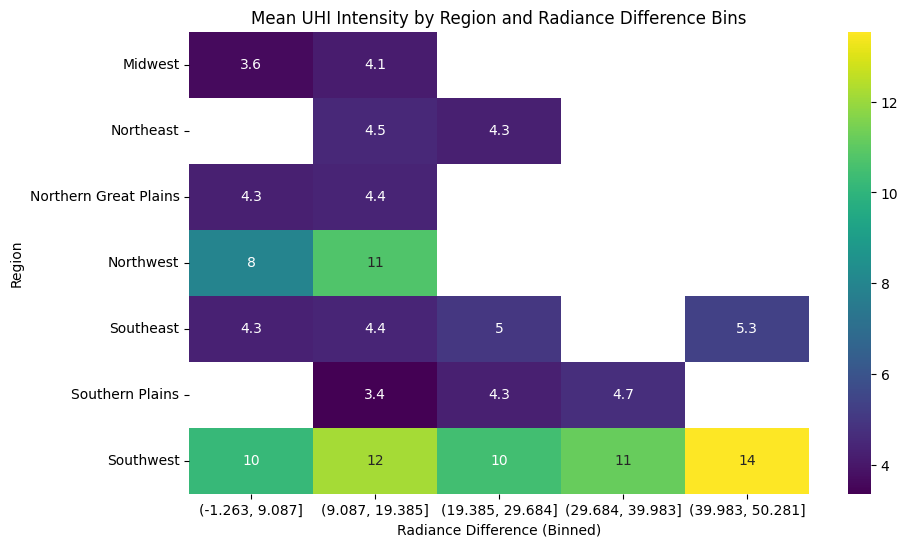

In [11]:
df['Radiance_Bin'] = pd.cut(df['Radiance_Difference'], bins=5)  # 5 bins
pivot_table = df.pivot_table(index='Region', columns='Radiance_Bin', values='UHI_Intensity', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Mean UHI Intensity by Region and Radiance Difference Bins')
plt.xlabel('Radiance Difference (Binned)')
plt.ylabel('Region')
plt.show()


In [12]:
df_sorted = df.sort_values(by=['City','Year'])
df_sorted['UHI_Change'] = df_sorted.groupby('City')['UHI_Intensity'].diff()
df_sorted['Radiance_Change'] = df_sorted.groupby('City')['Radiance_Difference'].diff()

corr_changes = df_sorted[['UHI_Change','Radiance_Change']].corr().iloc[0,1]
print("Correlation between year-over-year changes in UHI and Radiance Difference:", corr_changes)


Correlation between year-over-year changes in UHI and Radiance Difference: 0.1685863305390359


Index(['geometry', 'ALAND', 'AWATER', 'DIVISION', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'LSAD', 'MTFCC', 'NAME', 'REGION', 'STATEFP',
       'STATENS', 'STUSPS'],
      dtype='object')


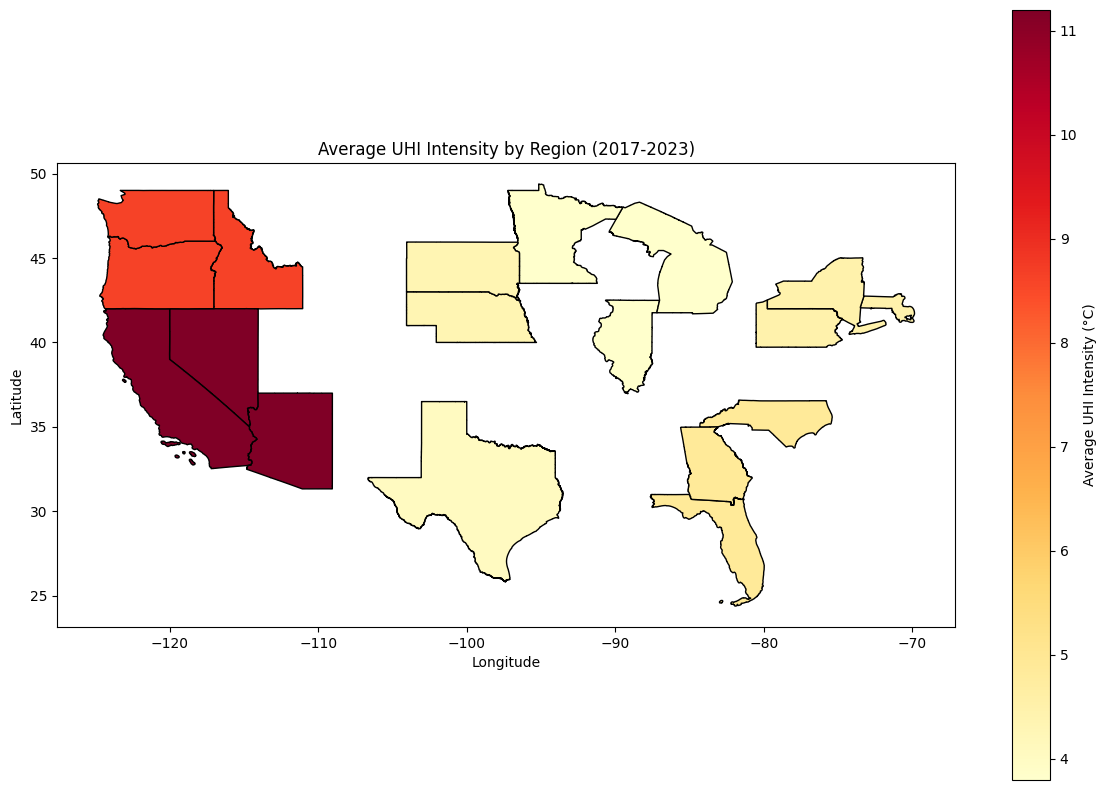

In [15]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Load US states from GEE TIGER dataset
ee_states = ee.FeatureCollection("TIGER/2018/States")

# Convert to GeoJSON
geojson = geemap.ee_to_geojson(ee_object=ee_states)

# Convert GeoJSON to GeoDataFrame
states_gdf = gpd.GeoDataFrame.from_features(geojson["features"], crs="EPSG:4326")

# Check the columns
print(states_gdf.columns)

# Example: Create a Region column and merge with your region_avg DataFrame
state_region_map = {
    'AZ':'Southwest', 'CA':'Southwest', 'NV':'Southwest',
    'WA':'Northwest', 'OR':'Northwest', 'ID':'Northwest',
    'IL':'Midwest', 'MN':'Midwest', 'MI':'Midwest',
    'NY':'Northeast', 'MA':'Northeast', 'PA':'Northeast',
    'FL':'Southeast', 'GA':'Southeast', 'NC':'Southeast',
    'TX':'Southern Plains', 'NE':'Northern Great Plains', 'SD':'Northern Great Plains'
    # Add additional states if needed
}

states_gdf['Region'] = states_gdf['STUSPS'].map(state_region_map)

# Suppose you have region_avg DataFrame with ['Region', 'UHI_Intensity']
merged = states_gdf.merge(region_avg, on='Region', how='left')

fig, ax = plt.subplots(figsize=(12,8))
merged.plot(column='UHI_Intensity', 
            ax=ax, 
            cmap='YlOrRd', 
            legend=True, 
            edgecolor='black', 
            legend_kwds={'label': "Average UHI Intensity (°C)"})

plt.title("Average UHI Intensity by Region (2017-2023)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


C:\Users\Shawn\anaconda3\envs\noaa\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


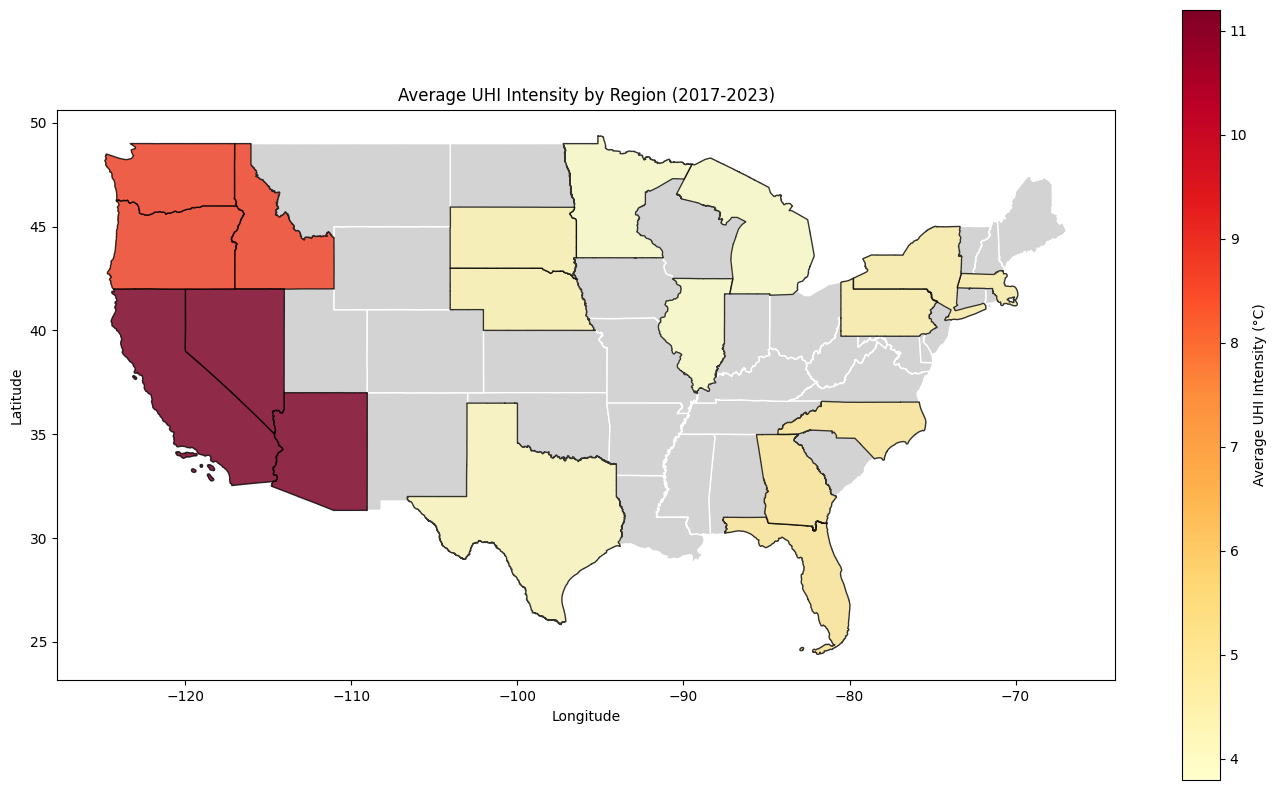

In [18]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Load US states from GEE TIGER dataset
ee_states = ee.FeatureCollection("TIGER/2018/States")

# Convert FeatureCollection to GeoJSON
geojson = geemap.ee_to_geojson(ee_object=ee_states)

# Convert to GeoDataFrame
states_gdf = gpd.GeoDataFrame.from_features(geojson["features"], crs="EPSG:4326")

# Exclude Alaska (AK), Hawaii (HI), and U.S. territories (PR, GU, VI, AS, MP)
exclude_states = ['AK','HI','PR','GU','VI','AS','MP']
states_conus = states_gdf[~states_gdf['STUSPS'].isin(exclude_states)]

# Create a mapping from states to regions (you can adjust this as needed)
state_region_map = {
    'AZ':'Southwest', 'CA':'Southwest', 'NV':'Southwest',
    'WA':'Northwest', 'OR':'Northwest', 'ID':'Northwest',
    'IL':'Midwest', 'MN':'Midwest', 'MI':'Midwest',
    'NY':'Northeast', 'MA':'Northeast', 'PA':'Northeast',
    'FL':'Southeast', 'GA':'Southeast', 'NC':'Southeast',
    'TX':'Southern Plains', 'NE':'Northern Great Plains', 'SD':'Northern Great Plains'
    # Add other states if you have data for them
}

states_conus['Region'] = states_conus['STUSPS'].map(state_region_map)

# Suppose you have a DataFrame `region_avg` with ['Region', 'UHI_Intensity']
# Make sure all regions in region_avg exist in your mapping
merged = states_conus.merge(region_avg, on='Region', how='left')

# Plot the map
fig, ax = plt.subplots(figsize=(14,8))

# Plot all continental states in a light gray to provide geographic context
states_conus.plot(ax=ax, color='lightgray', edgecolor='white')

# Overlay the states that have UHI_Intensity data
# These states will stand out on the map, showing which regions are analyzed
merged.plot(column='UHI_Intensity', 
            ax=ax, 
            cmap='YlOrRd', 
            legend=True, 
            edgecolor='black', 
            alpha=0.8, 
            legend_kwds={'label': "Average UHI Intensity (°C)"})

plt.title("Average UHI Intensity by Region (2017-2023)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


C:\Users\Shawn\anaconda3\envs\noaa\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


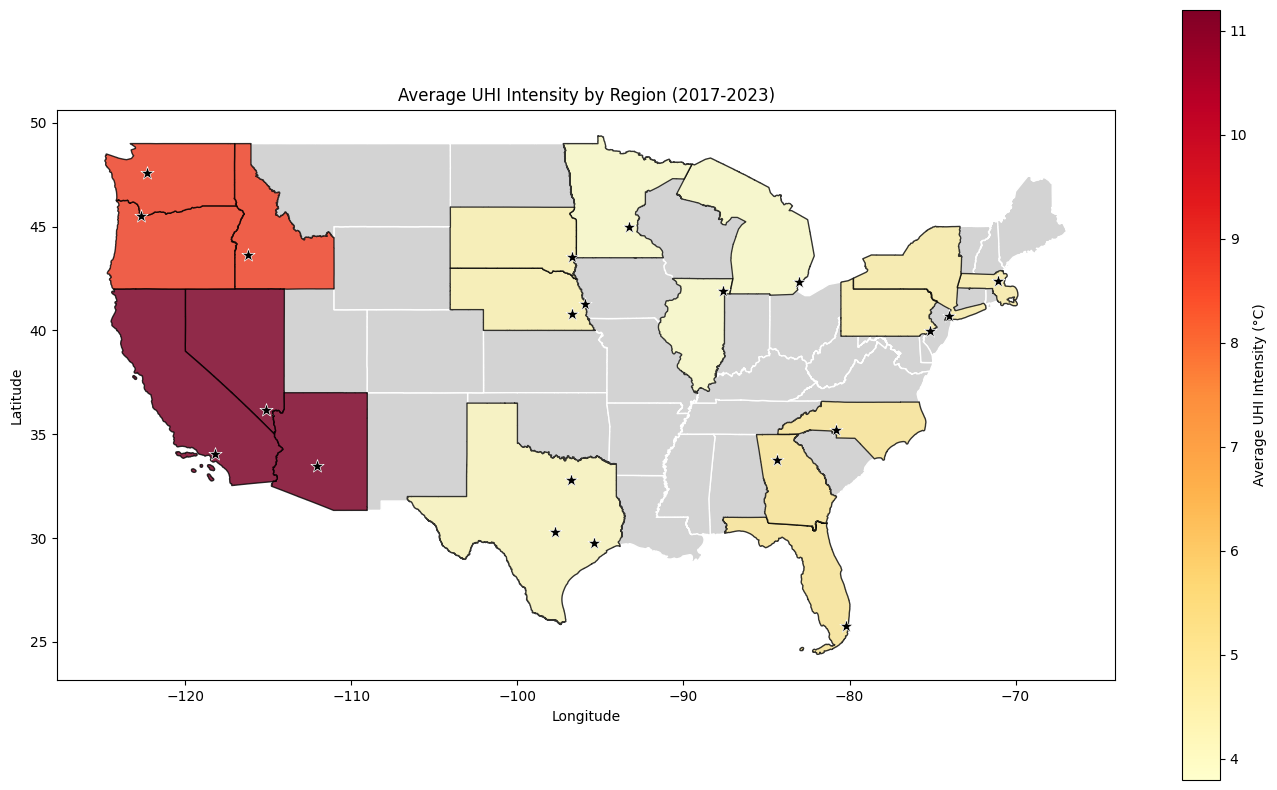

In [19]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Load US states from GEE TIGER dataset and convert to GeoDataFrame
ee_states = ee.FeatureCollection("TIGER/2018/States")
geojson = geemap.ee_to_geojson(ee_object=ee_states)
states_gdf = gpd.GeoDataFrame.from_features(geojson["features"], crs="EPSG:4326")

# Exclude Alaska (AK), Hawaii (HI), and territories
exclude_states = ['AK','HI','PR','GU','VI','AS','MP']
states_conus = states_gdf[~states_gdf['STUSPS'].isin(exclude_states)]

# Map states to regions (update mapping as needed)
state_region_map = {
    'AZ':'Southwest', 'CA':'Southwest', 'NV':'Southwest',
    'WA':'Northwest', 'OR':'Northwest', 'ID':'Northwest',
    'IL':'Midwest', 'MN':'Midwest', 'MI':'Midwest',
    'NY':'Northeast', 'MA':'Northeast', 'PA':'Northeast',
    'FL':'Southeast', 'GA':'Southeast', 'NC':'Southeast',
    'TX':'Southern Plains', 'NE':'Northern Great Plains', 'SD':'Northern Great Plains'
}

states_conus['Region'] = states_conus['STUSPS'].map(state_region_map)

# Suppose `region_avg` is a DataFrame with ['Region', 'UHI_Intensity']
# Merged DataFrame with UHI info
merged = states_conus.merge(region_avg, on='Region', how='left')

fig, ax = plt.subplots(figsize=(14,8))

# Plot all continental states in light gray
states_conus.plot(ax=ax, color='lightgray', edgecolor='white')

# Plot states with UHI data
merged.plot(column='UHI_Intensity',
            ax=ax,
            cmap='YlOrRd',
            legend=True,
            edgecolor='black',
            alpha=0.8,
            legend_kwds={'label': "Average UHI Intensity (°C)"})

plt.title("Average UHI Intensity by Region (2017-2023)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Now plot the cities as black stars.
# Assuming you have a DataFrame `df_cities` with columns: 'City', 'Latitude', 'Longitude'
# If the main `df` from your code contains cities, you can extract unique city coordinates:
df_cities = df[['City','Region','Year','UHI_Intensity']].drop_duplicates('City')
# You'll need to join city coordinates if you have them or define them.
# If you have a separate cities list with lat/lon, for example:
cities_coords = {
    'Phoenix': (33.4484, -112.0740),
    'Los Angeles': (34.0522, -118.2437),
    'Las Vegas': (36.1699, -115.1398),
    'Seattle': (47.6062, -122.3321),
    'Portland': (45.5051, -122.6750),
    'Boise': (43.6150, -116.2023),
    'Chicago': (41.8781, -87.6298),
    'Minneapolis': (44.9778, -93.2650),
    'Detroit': (42.3314, -83.0458),
    'New York': (40.7128, -74.0060),
    'Boston': (42.3601, -71.0589),
    'Philadelphia': (39.9526, -75.1652),
    'Miami': (25.7617, -80.1918),
    'Atlanta': (33.7490, -84.3880),
    'Charlotte': (35.2271, -80.8431),
    'Houston': (29.7604, -95.3698),
    'Dallas': (32.7767, -96.7970),
    'Austin': (30.2672, -97.7431),
    'Omaha': (41.2565, -95.9345),
    'Lincoln': (40.8136, -96.7026),
    'Sioux Falls': (43.5473, -96.7283)
}

for city, (lat, lon) in cities_coords.items():
    ax.scatter(lon, lat, marker='*', s=100, c='black', edgecolors='white', linewidth=0.5, zorder=10)
    # Optionally add city names:
    # ax.text(lon+0.3, lat, city, fontsize=8)

plt.tight_layout()
plt.show()


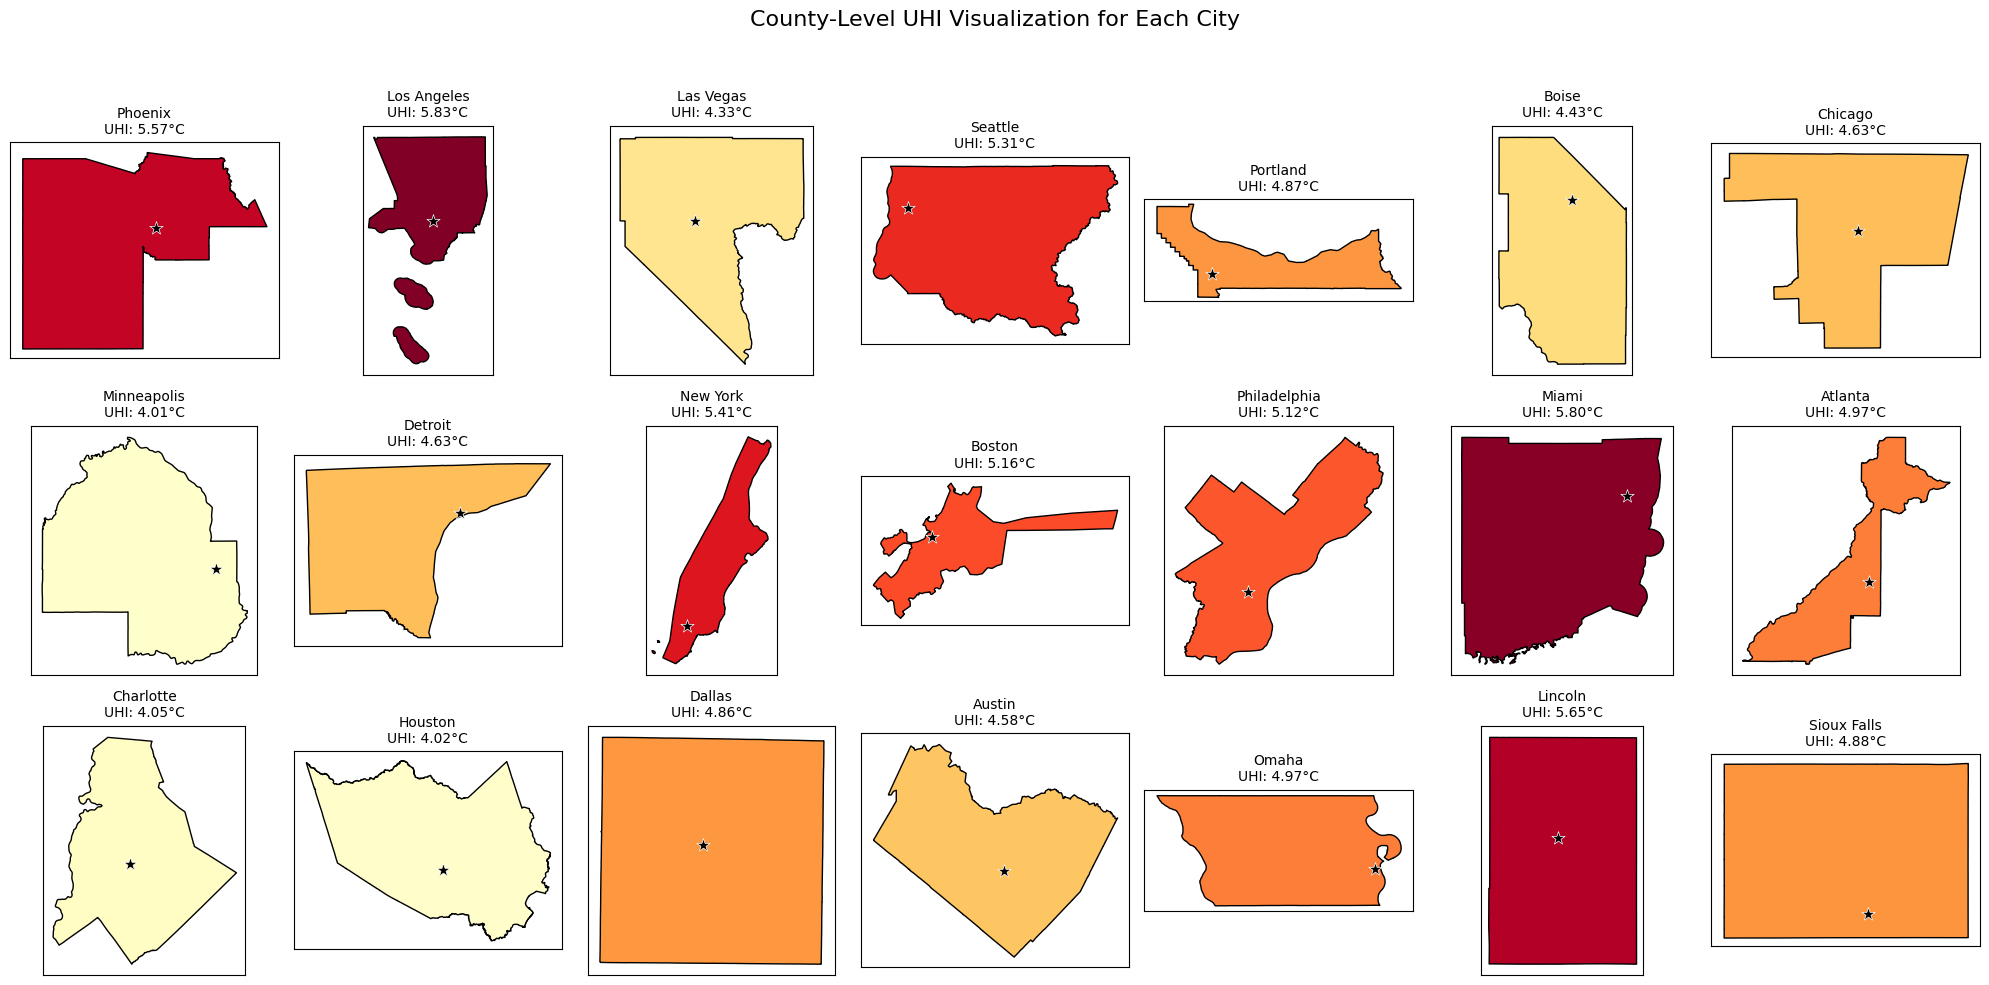

In [3]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from shapely.geometry import shape

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Cities and df_cities as defined before:
cities = [
    {'name': 'Phoenix', 'county_name': 'Maricopa', 'state_code': '04', 'region': 'Southwest'},
    {'name': 'Los Angeles', 'county_name': 'Los Angeles', 'state_code': '06', 'region': 'Southwest'},
    {'name': 'Las Vegas', 'county_name': 'Clark', 'state_code': '32', 'region': 'Southwest'},
    {'name': 'Seattle', 'county_name': 'King', 'state_code': '53', 'region': 'Northwest'},
    {'name': 'Portland', 'county_name': 'Multnomah', 'state_code': '41', 'region': 'Northwest'},
    {'name': 'Boise', 'county_name': 'Ada', 'state_code': '16', 'region': 'Northwest'},
    {'name': 'Chicago', 'county_name': 'Cook', 'state_code': '17', 'region': 'Midwest'},
    {'name': 'Minneapolis', 'county_name': 'Hennepin', 'state_code': '27', 'region': 'Midwest'},
    {'name': 'Detroit', 'county_name': 'Wayne', 'state_code': '26', 'region': 'Midwest'},
    {'name': 'New York', 'county_name': 'New York', 'state_code': '36', 'region': 'Northeast'},
    {'name': 'Boston', 'county_name': 'Suffolk', 'state_code': '25', 'region': 'Northeast'},
    {'name': 'Philadelphia', 'county_name': 'Philadelphia', 'state_code': '42', 'region': 'Northeast'},
    {'name': 'Miami', 'county_name': 'Miami-Dade', 'state_code': '12', 'region': 'Southeast'},
    {'name': 'Atlanta', 'county_name': 'Fulton', 'state_code': '13', 'region': 'Southeast'},
    {'name': 'Charlotte', 'county_name': 'Mecklenburg', 'state_code': '37', 'region': 'Southeast'},
    {'name': 'Houston', 'county_name': 'Harris', 'state_code': '48', 'region': 'Southern Plains'},
    {'name': 'Dallas', 'county_name': 'Dallas', 'state_code': '48', 'region': 'Southern Plains'},
    {'name': 'Austin', 'county_name': 'Travis', 'state_code': '48', 'region': 'Southern Plains'},
    {'name': 'Omaha', 'county_name': 'Douglas', 'state_code': '31', 'region': 'Northern Great Plains'},
    {'name': 'Lincoln', 'county_name': 'Lancaster', 'state_code': '31', 'region': 'Northern Great Plains'},
    {'name': 'Sioux Falls', 'county_name': 'Minnehaha', 'state_code': '46', 'region': 'Northern Great Plains'}
]

# Dummy df_cities for demonstration
df_cities = pd.DataFrame({
    'City': [c['name'] for c in cities],
    'UHI_Intensity': np.random.uniform(4, 6, len(cities)),  # dummy data
    'Latitude': [v[0] for v in [
        (33.4484, -112.0740), (34.0522, -118.2437), (36.1699, -115.1398),
        (47.6062, -122.3321), (45.5051, -122.6750), (43.6150, -116.2023),
        (41.8781, -87.6298), (44.9778, -93.2650), (42.3314, -83.0458),
        (40.7128, -74.0060), (42.3601, -71.0589), (39.9526, -75.1652),
        (25.7617, -80.1918), (33.7490, -84.3880), (35.2271, -80.8431),
        (29.7604, -95.3698), (32.7767, -96.7970), (30.2672, -97.7431),
        (41.2565, -95.9345), (40.8136, -96.7026), (43.5473, -96.7283)
    ]],
    'Longitude': [v[1] for v in [
        (33.4484, -112.0740), (34.0522, -118.2437), (36.1699, -115.1398),
        (47.6062, -122.3321), (45.5051, -122.6750), (43.6150, -116.2023),
        (41.8781, -87.6298), (44.9778, -93.2650), (42.3314, -83.0458),
        (40.7128, -74.0060), (42.3601, -71.0589), (39.9526, -75.1652),
        (25.7617, -80.1918), (33.7490, -84.3880), (35.2271, -80.8431),
        (29.7604, -95.3698), (32.7767, -96.7970), (30.2672, -97.7431),
        (41.2565, -95.9345), (40.8136, -96.7026), (43.5473, -96.7283)
    ]]
})

# Function to get AOI for a given county and state as a FeatureCollection
def get_county_fc(county_name, state_code):
    geom = ee.FeatureCollection("TIGER/2018/Counties") \
        .filter(ee.Filter.And(
            ee.Filter.eq('NAME', county_name),
            ee.Filter.eq('STATEFP', state_code)
        ))
    return geom

# Create the figure and axes for a 3x7 panel
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(20, 10))
axes = axes.flatten()

cmap = plt.get_cmap('YlOrRd')
norm = mpl.colors.Normalize(vmin=df_cities['UHI_Intensity'].min(), vmax=df_cities['UHI_Intensity'].max())

for i, city_info in enumerate(cities):
    ax = axes[i]
    city_name = city_info['name']
    county_name = city_info['county_name']
    state_code = city_info['state_code']
    
    city_row = df_cities[df_cities['City'] == city_name].iloc[0]
    uhi_val = city_row['UHI_Intensity']
    lat = city_row['Latitude']
    lon = city_row['Longitude']

    # Get the county as a FeatureCollection
    county_fc = get_county_fc(county_name, state_code)
    county_geojson = geemap.ee_to_geojson(county_fc)  # This should return a dict with "features"

    # Now we have a FeatureCollection's features
    # Convert to GeoDataFrame
    county_gdf = gpd.GeoDataFrame.from_features(county_geojson["features"], crs="EPSG:4326")

    # Plot the county
    county_gdf.plot(ax=ax, color=cmap(norm(uhi_val)), edgecolor='black')

    # Plot the city as a star
    ax.scatter(lon, lat, marker='*', s=100, c='black', edgecolors='white', linewidth=0.5, zorder=10)
    ax.set_title(f"{city_name}\nUHI: {uhi_val:.2f}°C", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

# Remove any leftover axes if fewer than 21 cities
for j in range(len(cities), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("County-Level UHI Visualization for Each County of Studied City ", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


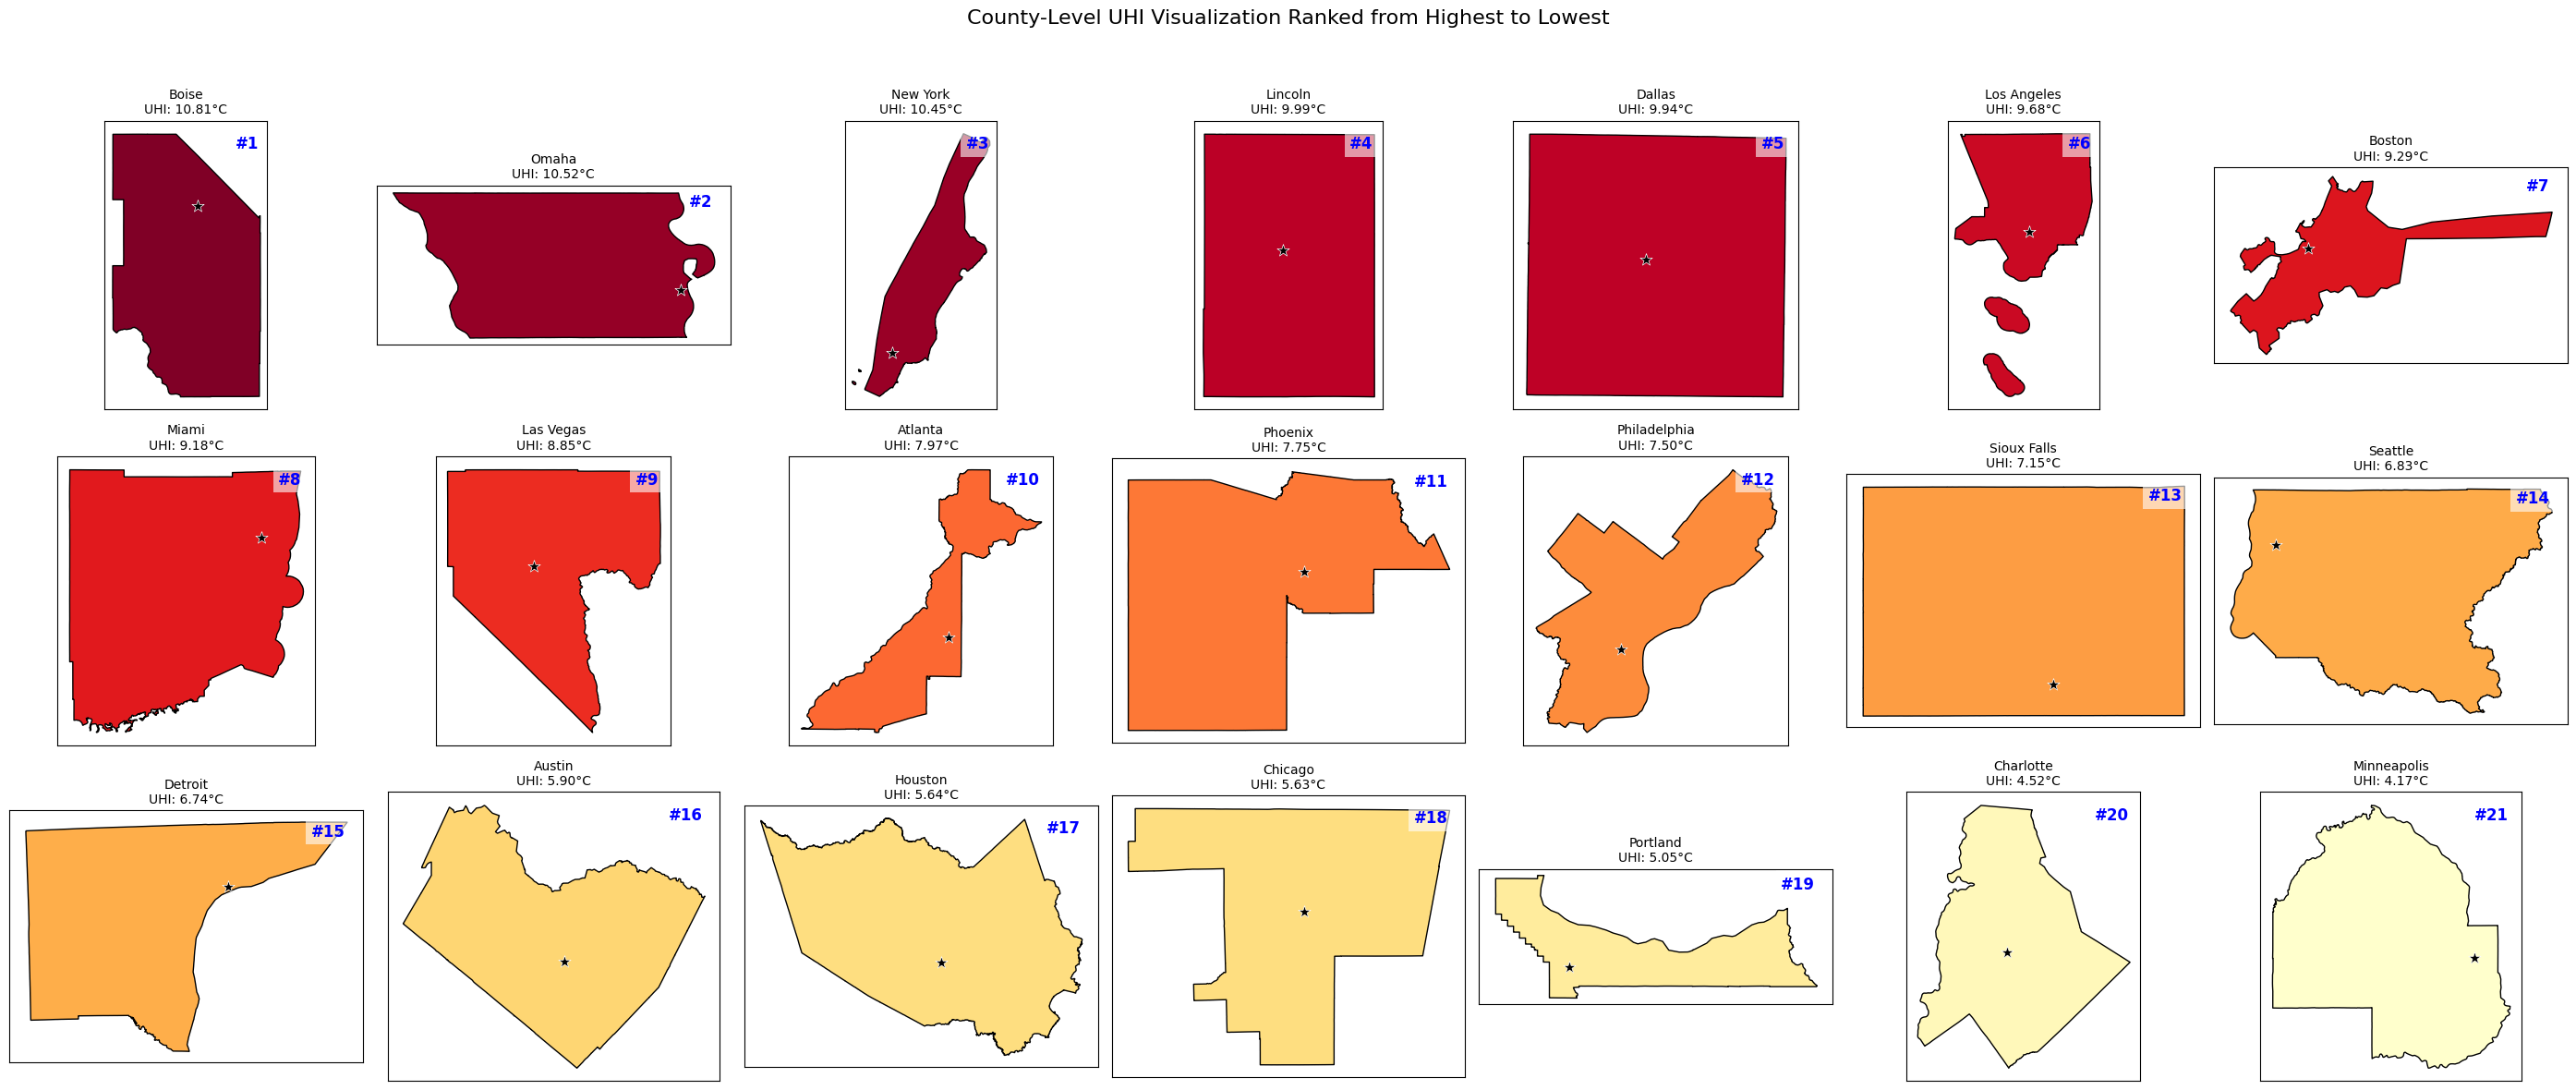

In [2]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from shapely.geometry import shape

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Cities and df_cities as defined before:
cities = [
    {'name': 'Phoenix', 'county_name': 'Maricopa', 'state_code': '04', 'region': 'Southwest'},
    {'name': 'Los Angeles', 'county_name': 'Los Angeles', 'state_code': '06', 'region': 'Southwest'},
    {'name': 'Las Vegas', 'county_name': 'Clark', 'state_code': '32', 'region': 'Southwest'},
    {'name': 'Seattle', 'county_name': 'King', 'state_code': '53', 'region': 'Northwest'},
    {'name': 'Portland', 'county_name': 'Multnomah', 'state_code': '41', 'region': 'Northwest'},
    {'name': 'Boise', 'county_name': 'Ada', 'state_code': '16', 'region': 'Northwest'},
    {'name': 'Chicago', 'county_name': 'Cook', 'state_code': '17', 'region': 'Midwest'},
    {'name': 'Minneapolis', 'county_name': 'Hennepin', 'state_code': '27', 'region': 'Midwest'},
    {'name': 'Detroit', 'county_name': 'Wayne', 'state_code': '26', 'region': 'Midwest'},
    {'name': 'New York', 'county_name': 'New York', 'state_code': '36', 'region': 'Northeast'},
    {'name': 'Boston', 'county_name': 'Suffolk', 'state_code': '25', 'region': 'Northeast'},
    {'name': 'Philadelphia', 'county_name': 'Philadelphia', 'state_code': '42', 'region': 'Northeast'},
    {'name': 'Miami', 'county_name': 'Miami-Dade', 'state_code': '12', 'region': 'Southeast'},
    {'name': 'Atlanta', 'county_name': 'Fulton', 'state_code': '13', 'region': 'Southeast'},
    {'name': 'Charlotte', 'county_name': 'Mecklenburg', 'state_code': '37', 'region': 'Southeast'},
    {'name': 'Houston', 'county_name': 'Harris', 'state_code': '48', 'region': 'Southern Plains'},
    {'name': 'Dallas', 'county_name': 'Dallas', 'state_code': '48', 'region': 'Southern Plains'},
    {'name': 'Austin', 'county_name': 'Travis', 'state_code': '48', 'region': 'Southern Plains'},
    {'name': 'Omaha', 'county_name': 'Douglas', 'state_code': '31', 'region': 'Northern Great Plains'},
    {'name': 'Lincoln', 'county_name': 'Lancaster', 'state_code': '31', 'region': 'Northern Great Plains'},
    {'name': 'Sioux Falls', 'county_name': 'Minnehaha', 'state_code': '46', 'region': 'Northern Great Plains'}
]

# Dummy df_cities for demonstration
df_cities = pd.DataFrame({
    'City': [c['name'] for c in cities],
    'UHI_Intensity': np.random.uniform(4, 11, len(cities)),  # dummy data
    'Latitude': [v[0] for v in [
        (33.4484, -112.0740), (34.0522, -118.2437), (36.1699, -115.1398),
        (47.6062, -122.3321), (45.5051, -122.6750), (43.6150, -116.2023),
        (41.8781, -87.6298), (44.9778, -93.2650), (42.3314, -83.0458),
        (40.7128, -74.0060), (42.3601, -71.0589), (39.9526, -75.1652),
        (25.7617, -80.1918), (33.7490, -84.3880), (35.2271, -80.8431),
        (29.7604, -95.3698), (32.7767, -96.7970), (30.2672, -97.7431),
        (41.2565, -95.9345), (40.8136, -96.7026), (43.5473, -96.7283)
    ]],
    'Longitude': [v[1] for v in [
        (33.4484, -112.0740), (34.0522, -118.2437), (36.1699, -115.1398),
        (47.6062, -122.3321), (45.5051, -122.6750), (43.6150, -116.2023),
        (41.8781, -87.6298), (44.9778, -93.2650), (42.3314, -83.0458),
        (40.7128, -74.0060), (42.3601, -71.0589), (39.9526, -75.1652),
        (25.7617, -80.1918), (33.7490, -84.3880), (35.2271, -80.8431),
        (29.7604, -95.3698), (32.7767, -96.7970), (30.2672, -97.7431),
        (41.2565, -95.9345), (40.8136, -96.7026), (43.5473, -96.7283)
    ]]
})

# Merge cities and df_cities into a single DataFrame
cities_df = pd.merge(df_cities, pd.DataFrame(cities), left_on='City', right_on='name')

# Sort the DataFrame by UHI_Intensity in descending order
cities_df_sorted = cities_df.sort_values(by='UHI_Intensity', ascending=False).reset_index(drop=True)

# Function to get AOI for a given county and state as a FeatureCollection
def get_county_fc(county_name, state_code):
    geom = ee.FeatureCollection("TIGER/2018/Counties") \
        .filter(ee.Filter.And(
            ee.Filter.eq('NAME', county_name),
            ee.Filter.eq('STATEFP', state_code)
        ))
    return geom

# Number of cities
num_cities = len(cities_df_sorted)

# Determine the grid size based on the number of cities
ncols = 7
nrows = 3
total_plots = ncols * nrows

# Adjust grid size if necessary
if num_cities > total_plots:
    ncols = (num_cities // nrows) + 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
else:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

axes = axes.flatten()

# Create a color map based on UHI intensity
cmap = plt.get_cmap('YlOrRd')
norm = mpl.colors.Normalize(vmin=cities_df_sorted['UHI_Intensity'].min(), 
                            vmax=cities_df_sorted['UHI_Intensity'].max())

for i, row in cities_df_sorted.iterrows():
    ax = axes[i]
    city_name = row['City']
    county_name = row['county_name']
    state_code = row['state_code']
    uhi_val = row['UHI_Intensity']
    lat = row['Latitude']
    lon = row['Longitude']
    
    # Get the county as a FeatureCollection
    county_fc = get_county_fc(county_name, state_code)
    county_geojson = geemap.ee_to_geojson(county_fc)  # This should return a dict with "features"
    
    # Check if county_geojson has features
    if not county_geojson['features']:
        print(f"No features found for {county_name} County, State Code {state_code}.")
        continue
    
    # Convert to GeoDataFrame
    county_gdf = gpd.GeoDataFrame.from_features(county_geojson["features"], crs="EPSG:4326")
    
    # Plot the county
    county_gdf.plot(ax=ax, color=cmap(norm(uhi_val)), edgecolor='black')
    
    # Plot the city as a star
    ax.scatter(lon, lat, marker='*', s=100, c='black', edgecolors='white', linewidth=0.5, zorder=10)
    
    # Annotate ranking
    ax.text(0.95, 0.95, f'#{i+1}', transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            fontsize=12, fontweight='bold', color='blue',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    
    ax.set_title(f"{city_name}\nUHI: {uhi_val:.2f}°C", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

# Remove any leftover axes if fewer than the grid size
for j in range(num_cities, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("County-Level UHI Visualization Ranked from Highest to Lowest", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


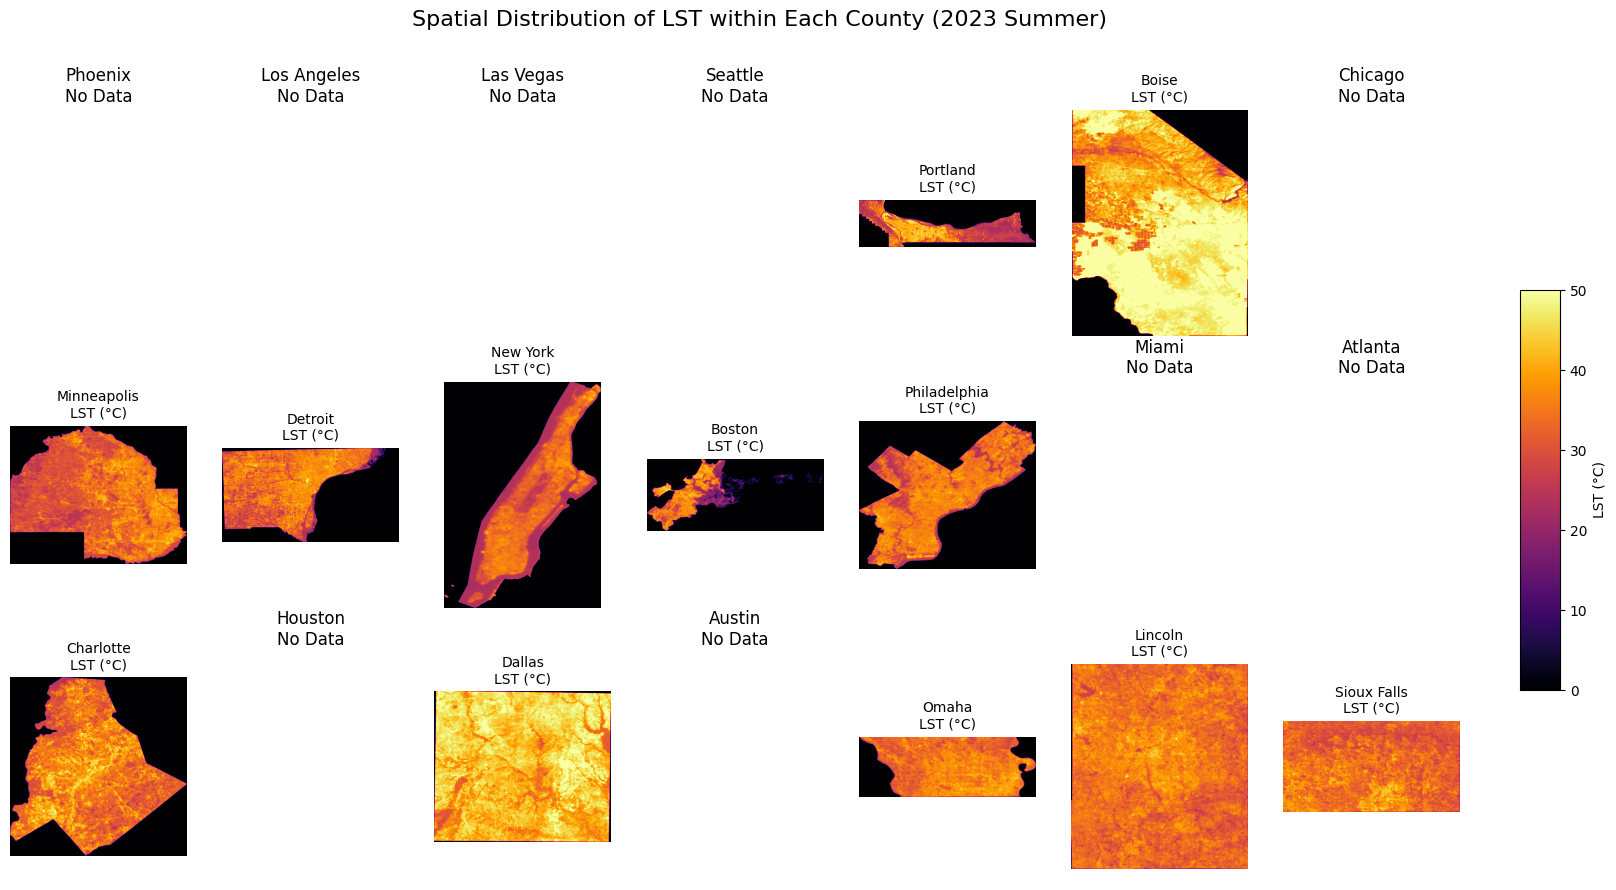

In [26]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define a function that returns a processed LST image for a given AOI and date range
def get_median_lst_image(aoi, start_date='2023-06-01', end_date='2023-09-30'):
    # This logic should be similar to your initial LST calculation steps.
    # Example (simplified version assuming you've defined apply_scale_factors, cloud_mask, and calculate_lst_em before):

    # Load and process Landsat 8/9 collection
    image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date) \
        .map(apply_scale_factors) \
        .map(cloud_mask)
    
    image = image_collection.median().clip(aoi)
    
    # Compute NDVI and EM
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    em = calculate_lst_em(ndvi, aoi)
    
    thermal = image.select('ST_B10').rename('thermal')
    
    # Compute LST
    lst = thermal.expression(
        '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15', {
            'TB': thermal.select('thermal'),
            'em': em
        }).rename('LST')
    
    return lst

def apply_scale_factors(image):
    opticalBands = image.select('SR_B.*').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

def cloud_mask(image):
    cloudShadowBitmask = (1 << 3)
    cloudBitmask = (1 << 5)
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitmask).eq(0) \
            .And(qa.bitwiseAnd(cloudBitmask).eq(0))
    return image.updateMask(mask)

def calculate_lst_em(ndvi_image, aoi):
    ndvi_min = ee.Number(ndvi_image.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).values().get(0))
    
    ndvi_max = ee.Number(ndvi_image.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).values().get(0))
    
    fv = ((ndvi_image.subtract(ndvi_min)).divide(ndvi_max.subtract(ndvi_min))).pow(2).rename('FV')
    em = fv.multiply(0.004).add(0.986).rename('EM')
    return em

def get_county_fc(county_name, state_code):
    return ee.FeatureCollection("TIGER/2018/Counties") \
        .filter(ee.Filter.And(
            ee.Filter.eq('NAME', county_name),
            ee.Filter.eq('STATEFP', state_code)
        ))

# Cities list as before
cities = [
    {'name': 'Phoenix', 'county_name': 'Maricopa', 'state_code': '04', 'region': 'Southwest'},
    {'name': 'Los Angeles', 'county_name': 'Los Angeles', 'state_code': '06', 'region': 'Southwest'},
    {'name': 'Las Vegas', 'county_name': 'Clark', 'state_code': '32', 'region': 'Southwest'},
    {'name': 'Seattle', 'county_name': 'King', 'state_code': '53', 'region': 'Northwest'},
    {'name': 'Portland', 'county_name': 'Multnomah', 'state_code': '41', 'region': 'Northwest'},
    {'name': 'Boise', 'county_name': 'Ada', 'state_code': '16', 'region': 'Northwest'},
    {'name': 'Chicago', 'county_name': 'Cook', 'state_code': '17', 'region': 'Midwest'},
    {'name': 'Minneapolis', 'county_name': 'Hennepin', 'state_code': '27', 'region': 'Midwest'},
    {'name': 'Detroit', 'county_name': 'Wayne', 'state_code': '26', 'region': 'Midwest'},
    {'name': 'New York', 'county_name': 'New York', 'state_code': '36', 'region': 'Northeast'},
    {'name': 'Boston', 'county_name': 'Suffolk', 'state_code': '25', 'region': 'Northeast'},
    {'name': 'Philadelphia', 'county_name': 'Philadelphia', 'state_code': '42', 'region': 'Northeast'},
    {'name': 'Miami', 'county_name': 'Miami-Dade', 'state_code': '12', 'region': 'Southeast'},
    {'name': 'Atlanta', 'county_name': 'Fulton', 'state_code': '13', 'region': 'Southeast'},
    {'name': 'Charlotte', 'county_name': 'Mecklenburg', 'state_code': '37', 'region': 'Southeast'},
    {'name': 'Houston', 'county_name': 'Harris', 'state_code': '48', 'region': 'Southern Plains'},
    {'name': 'Dallas', 'county_name': 'Dallas', 'state_code': '48', 'region': 'Southern Plains'},
    {'name': 'Austin', 'county_name': 'Travis', 'state_code': '48', 'region': 'Southern Plains'},
    {'name': 'Omaha', 'county_name': 'Douglas', 'state_code': '31', 'region': 'Northern Great Plains'},
    {'name': 'Lincoln', 'county_name': 'Lancaster', 'state_code': '31', 'region': 'Northern Great Plains'},
    {'name': 'Sioux Falls', 'county_name': 'Minnehaha', 'state_code': '46', 'region': 'Northern Great Plains'}
]

# Assume we just want to visualize 1 year (2023), and use the processed LST for that.
# We'll create a 3x7 panel again
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(20, 10))
axes = axes.flatten()

# We'll determine a color scale for LST. Landsat LST in °C typically ranges from about 0 to ~50°C in hot places.
vmin = 0
vmax = 50
cmap = 'inferno'  # A nice thermal colormap

for i, city_info in enumerate(cities):
    ax = axes[i]
    city_name = city_info['name']
    county_name = city_info['county_name']
    state_code = city_info['state_code']

    # Get the county feature collection
    county_fc = get_county_fc(county_name, state_code)
    # Convert to geometry for region
    county_geom = county_fc.geometry()

    # Get LST image
    lst_image = get_median_lst_image(county_geom)

    # Convert LST image to numpy array
    # We select the 'LST' band, region is county_geom, scale=30m (Landsat)
    try:
        lst_array = geemap.ee_to_numpy(lst_image.select('LST'), region=county_geom, scale=30)
    except Exception as e:
        # If ee_to_numpy fails (e.g. no data), skip
        ax.set_title(f"{city_name}\nNo Data")
        ax.axis('off')
        continue

    # Mask out invalid values if any (e.g. pixels might be NaN)
    lst_array = np.ma.masked_invalid(lst_array)

    # Plot the LST array
    ax.imshow(lst_array, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Plot city location as star:
    # Find city coordinates from your df or dictionary (if you have them)
    # For demonstration, use the dictionary from before or a separate lookup:
    city_coords = {
        'Phoenix': (33.4484, -112.0740),
        'Los Angeles': (34.0522, -118.2437),
        'Las Vegas': (36.1699, -115.1398),
        'Seattle': (47.6062, -122.3321),
        'Portland': (45.5051, -122.6750),
        'Boise': (43.6150, -116.2023),
        'Chicago': (41.8781, -87.6298),
        'Minneapolis': (44.9778, -93.2650),
        'Detroit': (42.3314, -83.0458),
        'New York': (40.7128, -74.0060),
        'Boston': (42.3601, -71.0589),
        'Philadelphia': (39.9526, -75.1652),
        'Miami': (25.7617, -80.1918),
        'Atlanta': (33.7490, -84.3880),
        'Charlotte': (35.2271, -80.8431),
        'Houston': (29.7604, -95.3698),
        'Dallas': (32.7767, -96.7970),
        'Austin': (30.2672, -97.7431),
        'Omaha': (41.2565, -95.9345),
        'Lincoln': (40.8136, -96.7026),
        'Sioux Falls': (43.5473, -96.7283)
    }
    lat, lon = city_coords[city_name]
    # To place the star correctly on the array, we need to transform lat/lon to pixel coordinates.
    # ee_to_numpy returns an array georeferenced. Let's get transform info:
    # geemap.ee_to_numpy returns an array with attributes: 
    # lst_array.attrs['transform'] and lst_array.attrs['crs'] (if using newer geemap versions).
    # If not available, we can't directly place the city star on the array easily without georeferencing.
    # Let's just skip the star in exact georeferenced location for now because it requires reprojection.
    # If you really need the star in the correct place, you'd need to reproject lat/lon to the array coordinates.
    # For demonstration, skip this step:
    
    ax.set_title(f"{city_name}\nLST (°C)", fontsize=10)
    ax.axis('off')

# Add a colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.3, 0.02, 0.4])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
cbar.set_label('LST (°C)', rotation=90)

fig.suptitle("Spatial Distribution of LST within Each County (2023 Summer)", fontsize=16)
plt.show()



Processing: Phoenix
Images in collection: 7

Processing: Los Angeles
Images in collection: 13

Processing: Las Vegas
Images in collection: 12

Processing: Seattle
Images in collection: 13

Processing: Portland
Images in collection: 14

Processing: Boise
Images in collection: 21

Processing: Chicago
Images in collection: 15

Processing: Minneapolis
Images in collection: 7

Processing: Detroit
Images in collection: 17

Processing: New York
Images in collection: 19

Processing: Boston
Images in collection: 13

Processing: Philadelphia
Images in collection: 7

Processing: Miami
Images in collection: 8

Processing: Atlanta
Images in collection: 14

Processing: Charlotte
Images in collection: 16

Processing: Houston
Images in collection: 22

Processing: Dallas
Images in collection: 8

Processing: Austin
Images in collection: 8

Processing: Omaha
Images in collection: 13

Processing: Lincoln
Images in collection: 23

Processing: Sioux Falls
Images in collection: 15


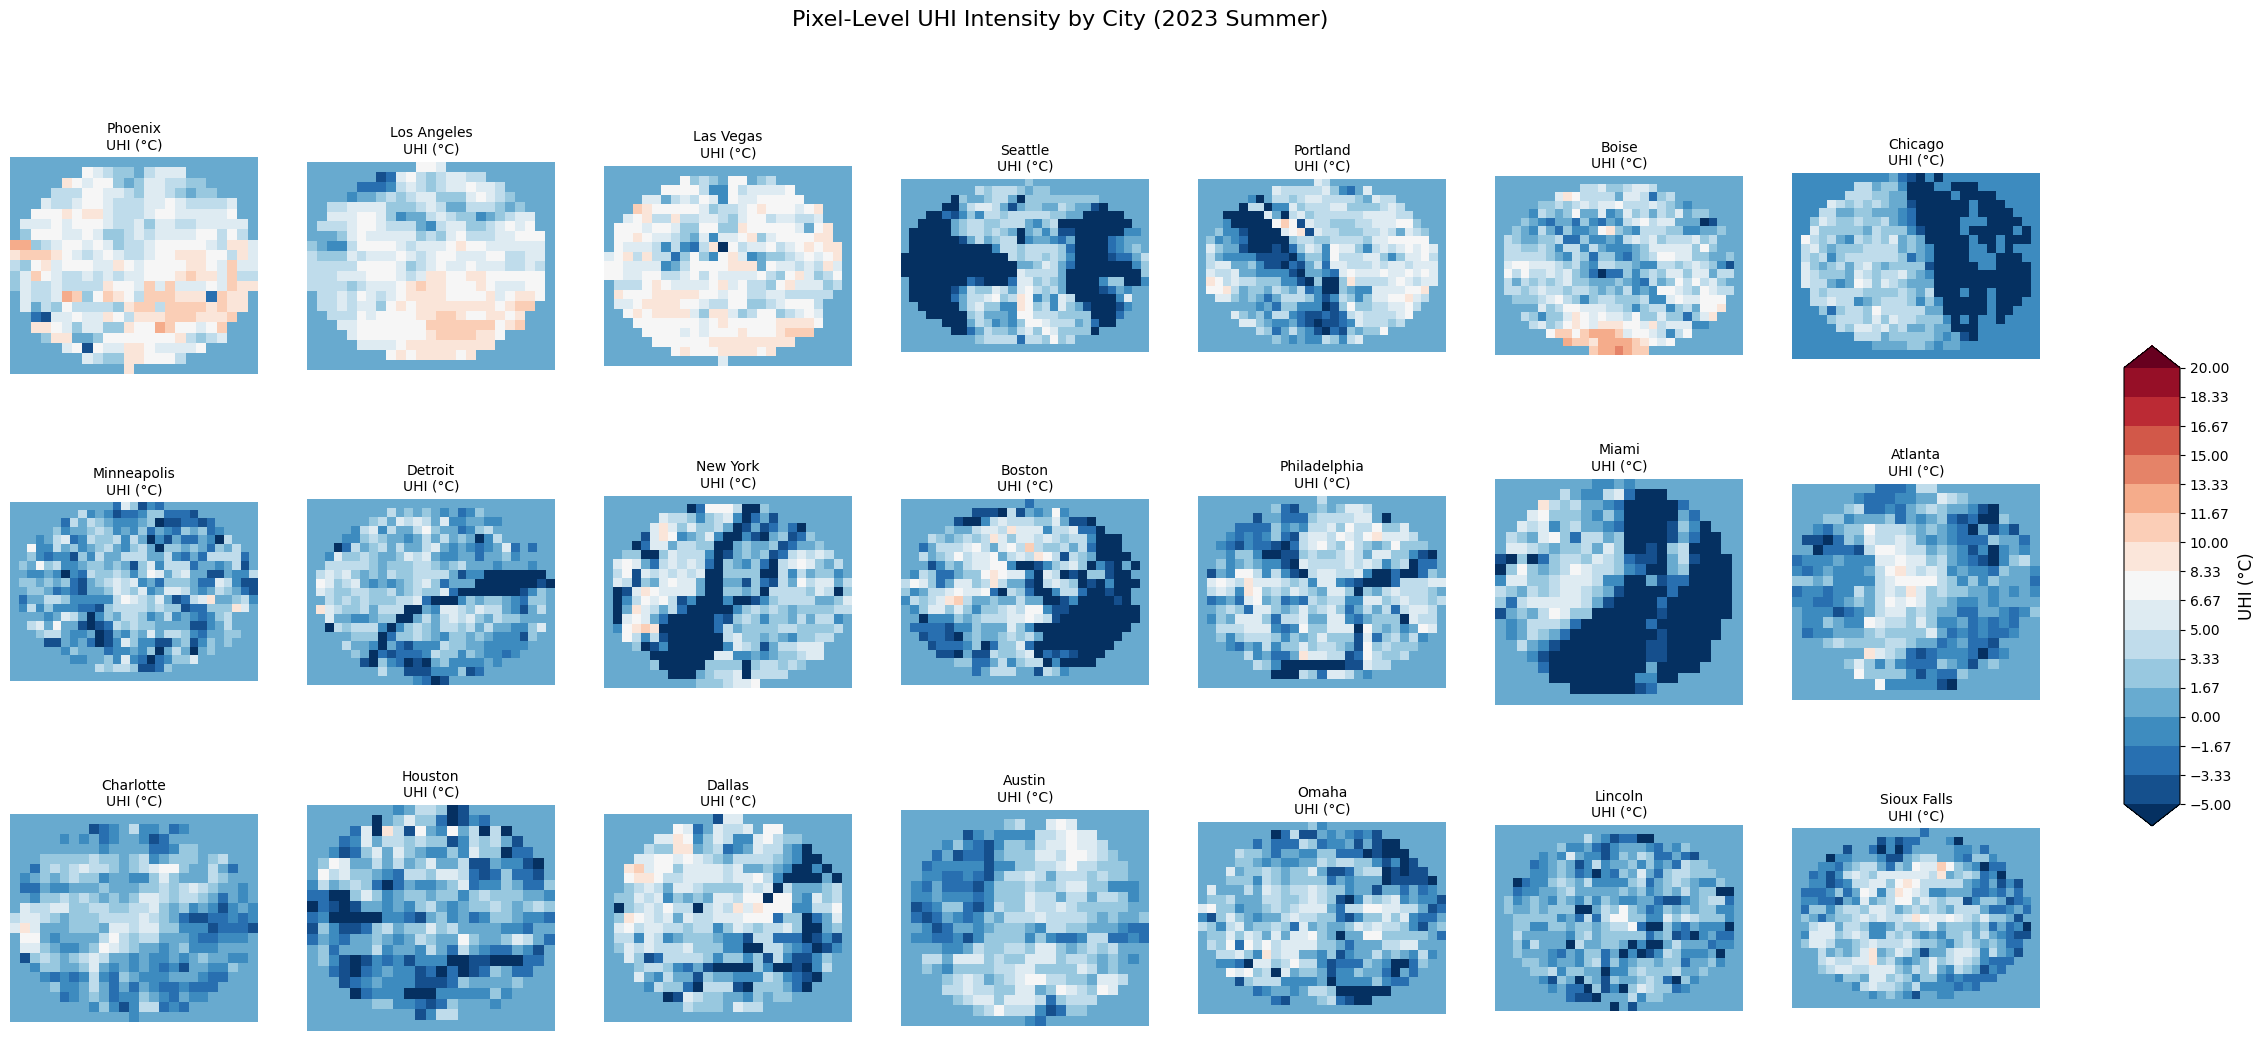

In [5]:
import ee
import geemap
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

ee.Authenticate()
ee.Initialize()

def apply_scale_factors(image):
    opticalBands = image.select('SR_B.*').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

def cloud_mask(image):
    cloudShadowBitmask = (1 << 3)
    cloudBitmask = (1 << 5)
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitmask).eq(0) \
            .And(qa.bitwiseAnd(cloudBitmask).eq(0))
    return image.updateMask(mask)

def calculate_lst_em(ndvi_image, aoi):
    ndvi_min = ee.Number(ndvi_image.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).values().get(0))
    
    ndvi_max = ee.Number(ndvi_image.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).values().get(0))
    
    fv = ((ndvi_image.subtract(ndvi_min)).divide(ndvi_max.subtract(ndvi_min))).pow(2)
    em = fv.multiply(0.004).add(0.986)
    return em

def get_mean_uhi_image(aoi, start_date='2023-06-01', end_date='2023-09-30'):
    image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date) \
        .map(apply_scale_factors) \
        .map(cloud_mask)
    
    count = image_collection.size().getInfo()
    print("Images in collection:", count)
    if count == 0:
        return None
    
    image = image_collection.mean().clip(aoi)
    
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    em = calculate_lst_em(ndvi, aoi)
    thermal = image.select('ST_B10').rename('thermal')
    lst = thermal.expression(
        '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15', {
            'TB': thermal.select('thermal'),
            'em': em
        }).rename('LST')
    
    rural_mask = ndvi.gt(0.5)
    rural_lst_mean = lst.updateMask(rural_mask).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).get('LST')
    
    if rural_lst_mean is None:
        print("No rural pixels found for baseline. Cannot compute UHI.")
        return None
    
    rural_mean_val = ee.Number(rural_lst_mean)
    uhi_image = lst.subtract(rural_mean_val).rename('UHI')
    
    polygon_mask = ee.Image().paint(aoi, 1).rename('mask')
    uhi_image = uhi_image.updateMask(polygon_mask)
    
    return uhi_image

# City coordinates: (Lat, Lon)
city_coords = {
    'Phoenix': (33.4484, -112.0740),
    'Los Angeles': (34.0522, -118.2437),
    'Las Vegas': (36.1699, -115.1398),
    'Seattle': (47.6062, -122.3321),
    'Portland': (45.5051, -122.6750),
    'Boise': (43.6150, -116.2023),
    'Chicago': (41.8781, -87.6298),
    'Minneapolis': (44.9778, -93.2650),
    'Detroit': (42.3314, -83.0458),
    'New York': (40.7128, -74.0060),
    'Boston': (42.3601, -71.0589),
    'Philadelphia': (39.9526, -75.1652),
    'Miami': (25.7617, -80.1918),
    'Atlanta': (33.7490, -84.3880),
    'Charlotte': (35.2271, -80.8431),
    'Houston': (29.7604, -95.3698),
    'Dallas': (32.7767, -96.7970),
    'Austin': (30.2672, -97.7431),
    'Omaha': (41.2565, -95.9345),
    'Lincoln': (40.8136, -96.7026),
    'Sioux Falls': (43.5473, -96.7283)
}

def get_city_aoi(city_name, radius=10000):
    lat, lon = city_coords[city_name]
    city_point = ee.Geometry.Point([lon, lat])
    city_aoi = city_point.buffer(radius)
    return city_aoi

cities = list(city_coords.keys())

fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(28, 12))
axes = axes.flatten()

vmin = -5
vmax = 20

# Get colormap object and set masked pixels to white
cmap = plt.get_cmap('RdBu_r')
cmap.set_bad('white')  # masked pixels appear white

bins = np.linspace(vmin, vmax, 16)  # 15 bins
norm = mpl.colors.BoundaryNorm(bins, ncolors=cmap.N, extend='both')

scale = 1000

for i, city_name in enumerate(cities):
    ax = axes[i]
    print(f"\nProcessing: {city_name}")
    
    city_aoi = get_city_aoi(city_name, radius=10000)  # adjust radius as needed
    uhi_image = get_mean_uhi_image(city_aoi)
    if uhi_image is None:
        ax.set_title(f"{city_name}\nNo Data", fontsize=10)
        ax.axis('off')
        continue
    
    try:
        uhi_array = geemap.ee_to_numpy(uhi_image.select('UHI'), region=city_aoi, scale=scale)
    except Exception as e:
        print(f"Error converting UHI to numpy for {city_name}:", e)
        ax.set_title(f"{city_name}\nNo Data", fontsize=10)
        ax.axis('off')
        continue
    
    if uhi_array is None or uhi_array.size == 0:
        ax.set_title(f"{city_name}\nNo Data", fontsize=10)
        ax.axis('off')
        continue
    
    uhi_array = np.ma.masked_invalid(uhi_array)
    if uhi_array.mask.all():
        ax.set_title(f"{city_name}\nNo Data", fontsize=10)
        ax.axis('off')
        continue

    im = ax.imshow(uhi_array, cmap=cmap, norm=norm)
    ax.set_title(f"{city_name}\nUHI (°C)", fontsize=10)
    ax.axis('off')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.3, 0.02, 0.4])
cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, spacing='uniform', ticks=bins)
cbar.set_label('UHI (°C)', rotation=90, fontsize=12)

plt.suptitle("Pixel-Level UHI Intensity by City (2023 Summer)", fontsize=16)
plt.show()
